# Online Payments Fraud Detection

Card fraud (or in-store payment fraud) is expected to decline over the next decade. However, cardless transactions (such as  online or  phone payments) continue to grow as a percentage of total spending and  are much more susceptible to fraud.

Payment fraud involves the unauthorized use of false or stolen payment information with the intent to steal money, goods, or services. (https://www.checkout.com/blog/common-types-of-online-payment-fraud) 

### About Dataset
The below column reference:

1. **step**: represents a unit of time where 1 step equals 1 hour
2. **type**: type of online transaction
3. **amount**: the amount of the transaction
4. **nameOrig**: customer starting the transaction
5. **oldbalanceOrg**: balance before the transaction
6. **newbalanceOrig**: balance after the transaction
7. **nameDest**: recipient of the transaction
8. **oldbalanceDest**: initial balance of recipient before the transaction
9. **newbalanceDest**: the new balance of recipient after the transaction
10. **isFraud**: fraud transaction

## Import Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.0f}'.format

In [2]:
import kagglehub
path = kagglehub.dataset_download("rupakroy/online-payments-fraud-detection-dataset")

In [3]:
df = pd.read_csv(path + "/PS_20174392719_1491204439457_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9840,C1231006815,170136,160296,M1979787155,0,0,0,0
1,1,PAYMENT,1864,C1666544295,21249,19385,M2044282225,0,0,0,0
2,1,TRANSFER,181,C1305486145,181,0,C553264065,0,0,1,0
3,1,CASH_OUT,181,C840083671,181,0,C38997010,21182,0,1,0
4,1,PAYMENT,11668,C2048537720,41554,29886,M1230701703,0,0,0,0


## Exploratory Data Analysis

### Explore general info and stats

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620
mean,243,179862,833883,855114,1100702,1224996,0,0
std,142,603858,2888243,2924049,3399180,3674129,0,0
min,1,0,0,0,0,0,0,0
25%,156,13390,0,0,0,0,0,0
50%,239,74872,14208,0,132706,214661,0,0
75%,335,208721,107315,144258,943037,1111909,0,0
max,743,92445517,59585040,49585040,356015889,356179279,1,1


In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
df.duplicated().sum()

- Dataset has 11 columns and 6,362,620 rows
- Dataset has 8 numerical columns and 3 categorical columns
- Dataset has no missing values
- Dataset has no duplicated rows
- Except for the <code>isFraud</code> column, all numerical columns are positively skewed and mean is not a good measurement of central tendency to these data due to excessive standard deviation

### Analysis of Target Column (isFraud)

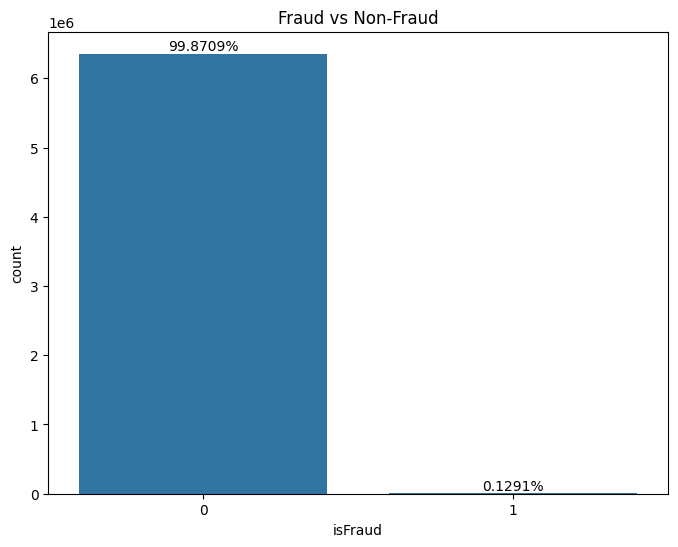

In [7]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs Non-Fraud')
total = len(df)
for p in ax.patches:
    percentage = '{:.4f}%'.format(100 * p.get_height()/total)
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5),
                textcoords='offset points')
plt.show()

In [8]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

The data imbalance is really visible in the plot above. This is a common thing around us, considering that if you compare the number of fraud cases with the total number of transactions, the comparison will be very small. In terms of building a Machine Learning model to detect fraud, this kind of data distribution is a problem. But don't worry, this problem can be overcome with various sampling techniques.

### Analysis of Transaction Type

In [10]:
df[['type','isFraud']].groupby('type').sum()

,isFraud
type,
CASH_IN,0
CASH_OUT,4116
DEBIT,0
PAYMENT,0
TRANSFER,4097


Most frauds occur in **cash out** and **transfer** transactions. This indicates that these types of transactions are more susceptible to fraudulent activities. While No fraud was detected in **cash in, debit**, and **payment** transactions in this dataset, suggesting that these transactions may inherently involve lower risk of fraudulent behavior.

In [19]:
cashout_transfer_df = df[['type','isFraud']].loc[(df['type'] == 'CASH_OUT') | (df['type'] == 'TRANSFER')]

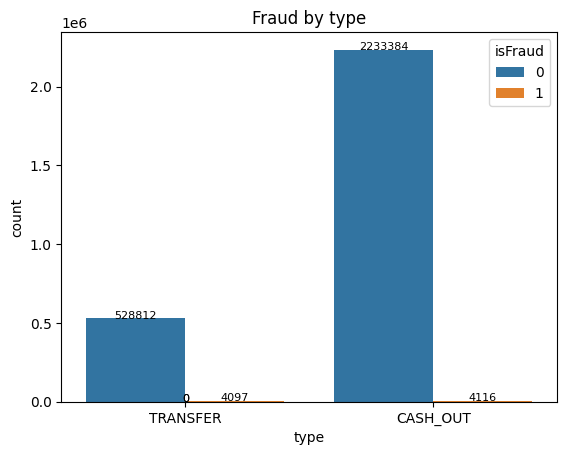

In [23]:
ax=sns.countplot(data=cashout_transfer_df, x="type", hue="isFraud")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha = 'center', fontsize=8, color='black', xytext=(0, 0), textcoords='offset points')
plt.title("Fraud by type")
plt.show()

### Analysis of Balance

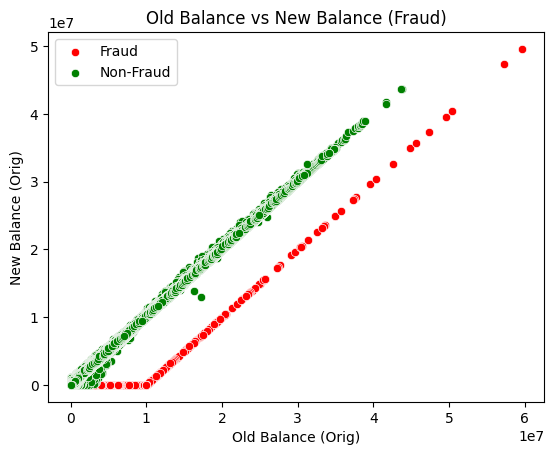

In [38]:
# Balance before and after transaction for fraud
fraud_df = df.loc[df['isFraud'] == 1]
non_fraud_df = df.loc[df['isFraud'] == 0]
sns.scatterplot(x='oldbalanceOrg', y='newbalanceOrig', data=fraud_df, color='red', label='Fraud')
sns.scatterplot(x='oldbalanceOrg', y='newbalanceOrig', data=non_fraud_df, color='green', label='Non-Fraud')
plt.title('Old Balance vs New Balance (Fraud)')
plt.xlabel('Old Balance (Orig)')
plt.ylabel('New Balance (Orig)')
plt.show()


The red (fraud) dots tend to be on a horizontal line where the New Balance is almost always close to zero, even though the Old Balance has a variety of values. This may indicate that fraudulent transactions often “drain” the balance to near zero, perhaps with the intention of cashing out completely.

In [40]:
# Contoh transaksi aneh
anomalies = df[(df['amount'] > 1000000) & (df['oldbalanceOrg'] == df['newbalanceOrig'])]
print("Transaksi aneh:\n", anomalies.head())
len(anomalies)

Transaksi aneh:
      step      type  amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
85      1  TRANSFER 1505626   C926859124              0               0   
89      1  TRANSFER 1429051  C1520267010              0               0   
94      1  TRANSFER 1724887  C1495608502              0               0   
358     1  TRANSFER 1538200   C476579021              0               0   
359     1  TRANSFER 2421578   C106297322              0               0   

        nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
85    C665576141           29031         5515763        0               0  
89   C1590550415         2041544        19169205        0               0  
94   C1590550415         3470595        19169205        0               0  
358  C1590550415         6977445        19169205        0               0  
359  C1590550415         8515646        19169205        0               0  


64781